In [13]:
import sys
sys.path.append('../')
from datasets import datasets as datat
from IForest_DODiMDS import iforest_D as IsolationForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
#from matplotlib.mlab import frange
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score
import matplotlib.cm as cm
from mpl_toolkits import mplot3d

## Chargement du jeu de données Shuttle

Shuttle contient 10 attributs dont le dernier est la classe à expliquer.
Il y a 46464 observations dont 878 anormales.
Avec le dernier attribut, nous avons les classes "o" pour les anomalies et "n" pour les observations normales.

In [14]:
dts = datat.reals_datasets()
X_Shuttle, y_transform_Shuttle = dts.Shuttle_Goldein()
X_Shuttle.describe()

,0,1,2,3,4,5,6,7
count,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000,46464.000000
mean,44.775482,-0.712509,84.834108,0.279291,38.652763,2.289708,40.070334,46.180419
std,8.753404,44.218007,8.731175,37.317203,15.902506,177.518356,10.969455,17.052467
min,27.000000,-4475.000000,21.000000,-3939.000000,-188.000000,-12809.000000,-26.000000,-353.000000
25%,37.000000,0.000000,79.000000,0.000000,34.000000,-4.000000,34.000000,35.000000
50%,43.000000,0.000000,83.000000,0.000000,42.000000,0.000000,39.000000,41.000000
75%,49.000000,0.000000,87.000000,0.000000,46.000000,5.000000,43.000000,52.000000
max,123.000000,1963.000000,149.000000,3830.000000,436.000000,15164.000000,105.000000,270.000000


## Chargement du jeu de données KDD99-Cup HTTP

KDD99-Cup HTTP contient 30 attributs dont le dernier est la classe à expliquer.
Il y a 620098 observations dont 1052 anormales.
Avec le dernier attribut, nous avons les classes "o" pour les anomalies et "n" pour les observations normales.

In [15]:
X_KDD99CUP, y_transform_KDD99CUP = dts.KDD99_Goldein()
X_KDD99CUP.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,620098.000000,620098.000000,6.200980e+05,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,...,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000,620098.000000
mean,0.627670,280.374673,4.099298e+03,0.005012,0.912428,0.000947,0.000318,0.000013,0.000010,0.005409,...,0.111720,127.698101,244.485422,0.996744,0.000796,0.074723,0.031820,0.001920,0.001473,0.087651
std,53.972528,1509.901935,2.369388e+04,0.098271,0.282671,0.045654,0.017821,0.003592,0.003111,0.073346,...,0.217532,105.897233,40.458619,0.033137,0.009522,0.185812,0.050689,0.030694,0.028037,0.274777
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,210.000000,4.580000e+02,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,22.000000,255.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,240.000000,1.425000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,96.000000,255.000000,1.000000,0.000000,0.010000,0.020000,0.000000,0.000000,0.000000
75%,0.000000,302.000000,3.731000e+03,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.140000,255.000000,255.000000,1.000000,0.000000,0.050000,0.040000,0.000000,0.000000,0.000000
max,41065.000000,54540.000000,1.173059e+07,21.000000,1.000000,21.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Generals settings

In [16]:
max_samples = 256
n_trees = 100
contamination = 0.1
threshold = 0.5

## Shuttle

### Exécution de Isolation Forest sur le jeux de données Shuttle en faisant varier n_estimators

### Etude de l'inconstance de IForest
Utilisant les valeurs par défaut des paramètres de IForest au niveau de scikit-learn

In [7]:
executions_numbers = range(10, 100, 10)

study_executions_time_IF_Shuttle = []
study_roc_auc_IF_Shuttle = []
study_recalls_IF_Shuttle = []
study_specificity_IF_Shuttle = []

for j in executions_numbers:
    start_IF_Shuttle = time()
        
    # Instanciation, fit and predict on Shuttle
    study_func_IF_Shuttle = IsolationForest.IsolationForest(sample_size = max_samples, n_trees=n_trees)
    study_func_IF_Shuttle.fit(X_Shuttle)
    study_y_pred_IF_Shuttle = study_func_IF_Shuttle.predict(X_Shuttle, threshold=threshold)

    # Calcul du temps d'exécution
    study_exec_time_IF_Shuttle = time() - start_IF_Shuttle
    study_executions_time_IF_Shuttle.append(study_exec_time_IF_Shuttle)
    
    # Recall
    study_recalls_IF_Shuttle.append(recall_score(y_transform_Shuttle, study_y_pred_IF_Shuttle))
    
    # Specificity
    study_specificity_IF_Shuttle.append(specificity_score(y_transform_Shuttle, study_y_pred_IF_Shuttle))
    
    # Calcul de l'aire sous la courbe ROC
    #study_y_DF_IF_Shuttle = study_func_IF_Shuttle.decision_function(X_Shuttle)
    #study_auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, study_y_DF_IF_Shuttle)
    study_auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, study_y_pred_IF_Shuttle)
    study_roc_auc_IF_Shuttle.append(study_auc_IF_Shuttle)

No handles with labels found to put in legend.


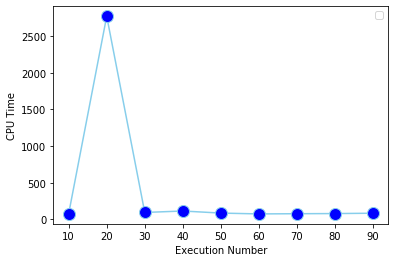

In [8]:
# Evolution de spécificité et rappel
#plt.plot( 'x', 'y1', data=df, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot(executions_numbers, study_executions_time_IF_Shuttle, "y-", marker='o', markerfacecolor='blue', markersize=12, color='skyblue')
#plt.title("Courbe Etude de l'inconstance de IForest")
#plt.axis([10, 90, 0, 4])
plt.xlabel('Execution Number')
plt.ylabel('CPU Time')
plt.legend(loc="best")
plt.savefig('inconstance_cputime.png')
plt.show()

No handles with labels found to put in legend.


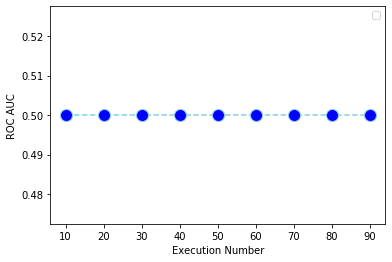

In [9]:
# Evolution de spécificité et rappel
plt.plot(executions_numbers, study_roc_auc_IF_Shuttle, "b--", marker='o', markerfacecolor='blue', markersize=12, color='skyblue')
#plt.title("Courbe Etude de l'inconstance de IForest")
#plt.axis([10, 90, 0, 4])
plt.xlabel('Execution Number')
plt.ylabel('ROC AUC')
plt.legend(loc="best")
plt.savefig('inconstance_rocauc.png')
plt.show()

No handles with labels found to put in legend.


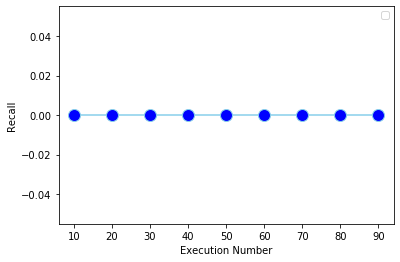

In [10]:
# Evolution de spécificité et rappel
plt.plot(executions_numbers, study_recalls_IF_Shuttle, "g-", marker='o', markerfacecolor='blue', markersize=12, color='skyblue')
#plt.title("Courbe Etude de l'inconstance de IForest")
#plt.axis([10, 90, 0, 4])
plt.xlabel('Execution Number')
plt.ylabel('Recall')
plt.legend(loc="best")
plt.savefig('inconstance_recall.png')
plt.show()

No handles with labels found to put in legend.


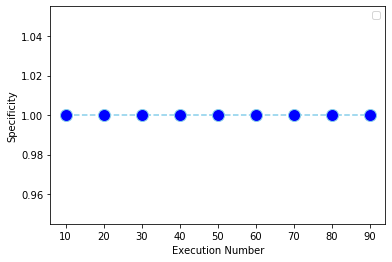

In [11]:
# Evolution de spécificité et rappel
plt.plot(executions_numbers, study_specificity_IF_Shuttle, "r--", marker='o', markerfacecolor='blue', markersize=12, color='skyblue')
#plt.title("Courbe Etude de l'inconstance de IForest")
#plt.axis([10, 90, 0, 4])
plt.xlabel('Execution Number')
plt.ylabel('Specificity')
plt.legend(loc="best")
plt.savefig('inconstance_specificity.png')
plt.show()

#### Conclusion
Malgré le caractère aléatoire de IForest, les métrics choisis ont tendance à être constant durant l'exécution successive avec les mêmes paramètres.

In [12]:
n_estimators_values = range(10, 1000, 10)

executions_time_IF_Shuttle = []
roc_auc_IF_Shuttle = []
precisions_IF_Shuttle = []
recalls_IF_Shuttle = []
f1_scores_IF_Shuttle = []
tn_IF_Shuttle = []
fp_IF_Shuttle = []
fn_IF_Shuttle = []
tp_IF_Shuttle = []
specificity_IF_Shuttle = []
n_estimators_IF_Shuttle = []

for j in n_estimators_values:
    print("n_estimators = "+str(j))
    n_estimators = j
    n_estimators_IF_Shuttle.append(j)
    start_IF_Shuttle = time()
        
    # Instanciation, fit and predict on Shuttle
    func_IF_Shuttle = IsolationForest.IsolationForest(sample_size = max_samples, n_trees=n_estimators)
    func_IF_Shuttle.fit(X_Shuttle)
    y_pred_IF_Shuttle = func_IF_Shuttle.predict(X_Shuttle, threshold=threshold)

    # Calcul du temps d'exécution
    exec_time_IF_Shuttle = time() - start_IF_Shuttle
    executions_time_IF_Shuttle.append(exec_time_IF_Shuttle)
    
    # Precision
    precisions_IF_Shuttle.append(precision_score(y_transform_Shuttle, y_pred_IF_Shuttle))
    
    # Recall
    recalls_IF_Shuttle.append(recall_score(y_transform_Shuttle, y_pred_IF_Shuttle))
    
    # f1_score
    f1_scores_IF_Shuttle.append(f1_score(y_transform_Shuttle, y_pred_IF_Shuttle))
    
    # Specificity
    specificity_IF_Shuttle.append(specificity_score(y_transform_Shuttle, y_pred_IF_Shuttle))
    
    # Matrice de confusion
    ttn, tfp, tfn, ttp = confusion_matrix(y_transform_Shuttle, y_pred_IF_Shuttle).ravel()
    tn = ttp
    fp = tfn
    fn = tfp
    tp = ttn
    tn_IF_Shuttle.append(tn)
    fp_IF_Shuttle.append(fp)
    fn_IF_Shuttle.append(fn)
    tp_IF_Shuttle.append(tp)
    
    # Calcul de l'aire sous la courbe ROC
    #y_DF_IF_Shuttle = func_IF_Shuttle.decision_function(X_Shuttle)
    auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, y_pred_IF_Shuttle)
    roc_auc_IF_Shuttle.append(auc_IF_Shuttle)
        
    #print("Execution time of IsolationForest applied on Shuttle (in second)")
    #print(executions_time_IF_Shuttle)
    #print("ROC AUC for Isolation Forest applied on Shuttle")
    #print(roc_auc_IF_Shuttle)

n_estimators = 10


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 20


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 30


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 40


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 50


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 60


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 70


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 80


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 90


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 110


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 120


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 130


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 140


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 150


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 160


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 170


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 180


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 190


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 200


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


n_estimators = 210


KeyboardInterrupt: 

### Résultat de Isolation Forest sur Shuttle

In [ ]:
plt.plot(n_estimators_values, executions_time_IF_Shuttle,  "g-", marker='.', markerfacecolor='blue', markersize=8, color='skyblue')
plt.xlabel('n_estimators')
plt.ylabel('CPU Time')
#plt.title("Execution time of IsolationForest applied on Shuttle (in second)")
plt.legend(loc="best")
plt.savefig('nestimators_cputime.png')
plt.show()

In [ ]:
plt.plot(n_estimators_values, roc_auc_IF_Shuttle,  "g-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
plt.xlabel('n_estimators')
plt.ylabel('ROC AUC')
#plt.title("ROC AUC for Isolation Forest applied on Shuttle")
plt.legend(loc="best")
plt.savefig('nestimators_rocauc.png')
plt.show()

In [ ]:
index = roc_auc_IF_Shuttle.index(max(roc_auc_IF_Shuttle))
print("La meilleure est "+str(max(roc_auc_IF_Shuttle))+" pour un temps d'exécution de "+str(executions_time_IF_Shuttle[index])+"s obtenue avec un n_estimators de "+str(n_estimators_IF_Shuttle[index])+" donnant un rappel de "+str(recalls_IF_Shuttle[index])+" et une spécificité de "+str(specificity_IF_Shuttle[index]))


In [ ]:
# Evolution de spécificité et rappel
plt.plot(n_estimators_IF_Shuttle, recalls_IF_Shuttle, "g-", marker='.', markerfacecolor='green', markersize=6, color='green')
#plt.axis([0, 1, 0, 1])
plt.xlabel('n_estimators')
plt.ylabel('Recall')
plt.legend(loc="best")
plt.savefig('nestimators_recall.png')
plt.show()

In [ ]:
# Evolution de spécificité et rappel
plt.plot(n_estimators_IF_Shuttle, specificity_IF_Shuttle, "b-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
#plt.title("Courbe Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('n_estimators')
plt.ylabel('Specificity')
plt.legend(loc="best")
plt.savefig('nestimators_specificity.png')
plt.show()

In [ ]:
plt.scatter(specificity_IF_Shuttle,recalls_IF_Shuttle, c=n_estimators_IF_Shuttle, cmap=cm.hsv)
cbar= plt.colorbar()
plt.show()

In [ ]:
plt.scatter(specificity_IF_Shuttle,recalls_IF_Shuttle, c=roc_auc_IF_Shuttle, cmap=cm.hsv)
cbar= plt.colorbar()
plt.show()

### Résultat
###### Faisant varier n_estimators et max_samples = 256, contamination = 0,1
L'augmentation du nombre d'arbres augmente le temps d'exécution. L'écart est léger 
la AUC est aléatoire avec quelques pics. 
Quelque soit le nombre d'estimateur, la AUC > 0,99

Meilleure estimation :
    La meilleure est 0.998458894235502 pour un temps d'exécution de 8.09360408782959s obtenue avec un n_estimators de 180 donnant un rappel de 0.917189488000702 et une spécificité de 0.9931662870159453

Le nombre d'estimateur a une influence sur la performance de IForest pouvant l'améliorer comme la détérioré. Cela s'explique par le caractère aléatoire de la construction de l'arbre.

### Exécution de Isolation Forest sur le jeux de données Shuttle en faisant varier max_samples

In [19]:
MS_executions_time_IF_Shuttle = []
MS_roc_auc_IF_Shuttle = []
MS_precisions_IF_Shuttle = []
MS_recalls_IF_Shuttle = []
MS_f1_scores_IF_Shuttle = []
MS_tn_IF_Shuttle = []
MS_fp_IF_Shuttle = []
MS_fn_IF_Shuttle = []
MS_tp_IF_Shuttle = []
MS_specificity_IF_Shuttle = []
MS_max_samples_IF_Shuttle = []

for j in range(100, len(X_Shuttle), 1000):
    print("max_samples = "+str(j))
    max_samples = j
    MS_max_samples_IF_Shuttle.append(j)
    start_IF_Shuttle = time()
        
    # Instanciation, fit and predict on Shuttle
    MS_func_IF_Shuttle = IsolationForest.IsolationForest(sample_size = max_samples, n_trees=n_trees)
    MS_func_IF_Shuttle.fit(X_Shuttle)
    MS_y_pred_IF_Shuttle = MS_func_IF_Shuttle.predict(X_Shuttle, threshold=threshold)

    # Calcul du temps d'exécution
    MS_exec_time_IF_Shuttle = time() - start_IF_Shuttle
    MS_executions_time_IF_Shuttle.append(MS_exec_time_IF_Shuttle)
    
    # Precision
    MS_precisions_IF_Shuttle.append(precision_score(y_transform_Shuttle, MS_y_pred_IF_Shuttle))
    
    # Recall
    MS_recalls_IF_Shuttle.append(recall_score(y_transform_Shuttle, MS_y_pred_IF_Shuttle))
    
    # f1_score
    MS_f1_scores_IF_Shuttle.append(f1_score(y_transform_Shuttle, MS_y_pred_IF_Shuttle))
    
    # Specificity
    MS_specificity_IF_Shuttle.append(specificity_score(y_transform_Shuttle, MS_y_pred_IF_Shuttle))
    
    # Matrice de confusion
    ttn, tfp, tfn, ttp = confusion_matrix(y_transform_Shuttle, MS_y_pred_IF_Shuttle).ravel()
    tn = ttp
    fp = tfn
    fn = tfp
    tp = ttn
    MS_tn_IF_Shuttle.append(tn)
    MS_fp_IF_Shuttle.append(fp)
    MS_fn_IF_Shuttle.append(fn)
    MS_tp_IF_Shuttle.append(tp)
    
    # Calcul de l'aire sous la courbe ROC
    MS_y_DF_IF_Shuttle = MS_func_IF_Shuttle.decision_function(X_Shuttle)
    MS_auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, MS_y_DF_IF_Shuttle)
    MS_roc_auc_IF_Shuttle.append(MS_auc_IF_Shuttle)
    

max_samples = 100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 1100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 2100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 3100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 4100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 5100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 6100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 7100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 8100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 9100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 10100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 11100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 12100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 13100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 14100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 15100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 16100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 17100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 18100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 19100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 20100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 21100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 22100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 23100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 24100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 25100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 26100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 27100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 28100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 29100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 30100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 31100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 32100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 33100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 34100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 35100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 36100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 37100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 38100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 39100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 40100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 41100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 42100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 43100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 44100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 45100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


max_samples = 46100


/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


No handles with labels found to put in legend.


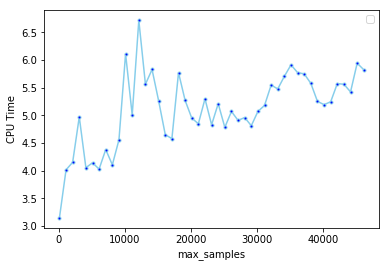

In [20]:
plt.plot(MS_max_samples_IF_Shuttle, MS_executions_time_IF_Shuttle,  "g-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
plt.xlabel('max_samples')
plt.ylabel('CPU Time')
#plt.title("Execution time of IsolationForest applied on Shuttle (in second)")
plt.legend(loc="best")
plt.savefig('maxsamples_cputime.png')
plt.show()

No handles with labels found to put in legend.


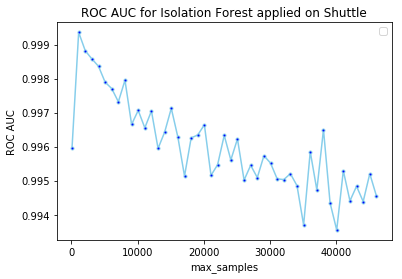

In [21]:
plt.plot(MS_max_samples_IF_Shuttle, MS_roc_auc_IF_Shuttle,  "g-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
plt.xlabel('max_samples')
plt.ylabel('ROC AUC')
plt.title("ROC AUC for Isolation Forest applied on Shuttle")
plt.legend(loc="best")
plt.savefig('maxsamples_rocauc.png')
plt.show()

In [22]:
MS_index = MS_roc_auc_IF_Shuttle.index(max(MS_roc_auc_IF_Shuttle))
print("La meilleure est "+str(max(MS_roc_auc_IF_Shuttle))+" pour un temps d'exécution de "+str(MS_executions_time_IF_Shuttle[MS_index])+"s obtenue avec un max_samples de "+str(MS_max_samples_IF_Shuttle[MS_index])+" donnant un rappel de "+str(MS_recalls_IF_Shuttle[MS_index])+" et une spécificité de "+str(MS_specificity_IF_Shuttle[MS_index]))


La meilleure est 0.9993617160765599 pour un temps d'exécution de 4.013896226882935s obtenue avec un max_samples de 1100 donnant un rappel de 0.917321107357522 et une spécificité de 1.0


No handles with labels found to put in legend.


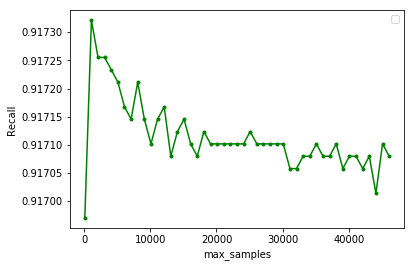

In [23]:
# Evolution de spécificité et rappel
plt.plot(MS_max_samples_IF_Shuttle, MS_recalls_IF_Shuttle, "g-", marker='.', markerfacecolor='green', markersize=6, color='green')
#plt.title("Courbe Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('max_samples')
plt.ylabel('Recall')
plt.legend(loc="best")
plt.savefig('maxsamples_recall.png')
plt.show()

No handles with labels found to put in legend.


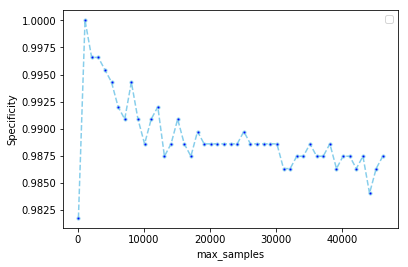

In [24]:
# Evolution de spécificité et rappel
plt.plot(MS_max_samples_IF_Shuttle, MS_specificity_IF_Shuttle, "b--", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
#plt.title("Courbe Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('max_samples')
plt.ylabel('Specificity')
plt.legend(loc="best")
plt.savefig('maxsamples_specificity.png')
plt.show()

### Résultat
###### Faisant varier max_samples, n_estimators = 100, contamination = 0,1
Plus le nombre d'éléments dans l'échantillon augmente, plus le temps d'exécution est long.
Par contre, quelque soit max_samples, la AUC ne varie pas beaucoup : entre 0,994 et 0,999.

Meilleure estimation :
    La meilleure est 0.9988092295850334 pour un temps d'exécution de 4.553619146347046s obtenue avec un max_samples de 2100 donnant un rappel de 0.917255297679112 et une spécificité de 0.9965831435079726

Max_samples n'a donc pas une grande incidence sur les performances de classification de IForest pour un jeu de données de taille et de dimension faibles. Mais il a une conséquences sur le temps d'exécution.

### Exécution de Isolation Forest sur le jeux de données Shuttle en faisant varier contamination (contamination : float in (0., 0.5), optional (default=0.1))

In [17]:
CONT_executions_time_IF_Shuttle = []
CONT_roc_auc_IF_Shuttle = []
CONT_precisions_IF_Shuttle = []
CONT_recalls_IF_Shuttle = []
CONT_f1_scores_IF_Shuttle = []
CONT_tn_IF_Shuttle = []
CONT_fp_IF_Shuttle = []
CONT_fn_IF_Shuttle = []
CONT_tp_IF_Shuttle = []
CONT_specificity_IF_Shuttle = []
CONT_contamination_IF_Shuttle = []

for j in np.arange(0.1, 1., 0.1):
    print("contamination = "+str(j))
    contamination = j
    CONT_contamination_IF_Shuttle.append(j)
    start_IF_Shuttle = time()
        
    # Instanciation, fit and predict on Shuttle
    CONT_func_IF_Shuttle = IsolationForest.IsolationForest(sample_size = max_samples, n_trees=n_trees)
    CONT_func_IF_Shuttle.fit(X_Shuttle)
    CONT_y_pred_IF_Shuttle = CONT_func_IF_Shuttle.predict(X_Shuttle, threshold=contamination)

    # Calcul du temps d'exécution
    CONT_exec_time_IF_Shuttle = time() - start_IF_Shuttle
    CONT_executions_time_IF_Shuttle.append(CONT_exec_time_IF_Shuttle)
    
    # Precision
    CONT_precisions_IF_Shuttle.append(precision_score(y_transform_Shuttle, CONT_y_pred_IF_Shuttle))
    
    # Recall
    CONT_recalls_IF_Shuttle.append(recall_score(y_transform_Shuttle, CONT_y_pred_IF_Shuttle))
    
    # f1_score
    CONT_f1_scores_IF_Shuttle.append(f1_score(y_transform_Shuttle, CONT_y_pred_IF_Shuttle))
    
    # Specificity
    CONT_specificity_IF_Shuttle.append(specificity_score(y_transform_Shuttle, CONT_y_pred_IF_Shuttle))
    
    # Matrice de confusion
    ttn, tfp, tfn, ttp = confusion_matrix(y_transform_Shuttle, CONT_y_pred_IF_Shuttle).ravel()
    tn = ttp
    fp = tfn
    fn = tfp
    tp = ttn
    CONT_tn_IF_Shuttle.append(tn)
    CONT_fp_IF_Shuttle.append(fp)
    CONT_fn_IF_Shuttle.append(fn)
    CONT_tp_IF_Shuttle.append(tp)
    
    # Calcul de l'aire sous la courbe ROC
    #CONT_y_DF_IF_Shuttle = CONT_func_IF_Shuttle.decision_function(X_Shuttle)
    CONT_auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, CONT_y_pred_IF_Shuttle)
    CONT_roc_auc_IF_Shuttle.append(CONT_auc_IF_Shuttle)

contamination = 0.1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


contamination = 0.2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


contamination = 0.30000000000000004


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


contamination = 0.4


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


contamination = 0.5


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


contamination = 0.6
contamination = 0.7000000000000001
contamination = 0.8
contamination = 0.9


No handles with labels found to put in legend.


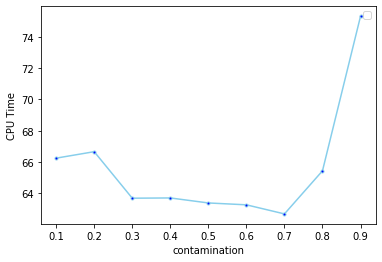

In [18]:
plt.plot(CONT_contamination_IF_Shuttle, CONT_executions_time_IF_Shuttle,  "g-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
plt.xlabel('contamination')
plt.ylabel('CPU Time')
#plt.title("Execution time of IsolationForest applied on Shuttle (in second)")
plt.legend(loc="best")
plt.savefig('contamination_cputime.png')
plt.show()

No handles with labels found to put in legend.


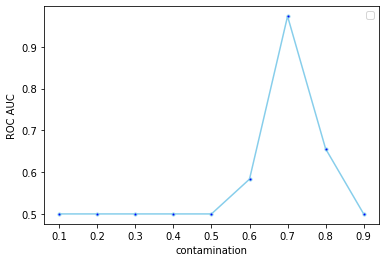

In [19]:
plt.plot(CONT_contamination_IF_Shuttle, CONT_roc_auc_IF_Shuttle,  "g-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
plt.xlabel('contamination')
plt.ylabel('ROC AUC')
#plt.title("ROC AUC for Isolation Forest applied on Shuttle")
plt.legend(loc="best")
plt.savefig('contamination_rocauc.png')
plt.show()

In [20]:
CONT_index = CONT_roc_auc_IF_Shuttle.index(max(CONT_roc_auc_IF_Shuttle))
print("La meilleure est "+str(max(CONT_roc_auc_IF_Shuttle))+" pour un temps d'exécution de "+str(CONT_executions_time_IF_Shuttle[CONT_index])+"s obtenue avec une contamination de "+str(CONT_contamination_IF_Shuttle[CONT_index])+" donnant un rappel de "+str(CONT_recalls_IF_Shuttle[CONT_index])+" et une spécificité de "+str(CONT_specificity_IF_Shuttle[CONT_index]))


La meilleure est 0.9734066937187585 pour un temps d'exécution de 62.666789054870605s obtenue avec une contamination de 0.7000000000000001 donnant un rappel de 0.9673145263896811 et une spécificité de 0.979498861047836


No handles with labels found to put in legend.


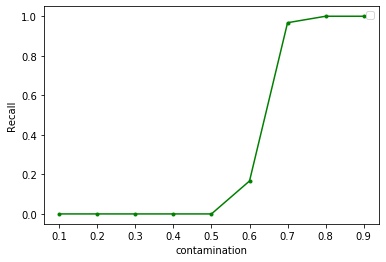

In [21]:
# Evolution de spécificité et rappel
plt.plot(CONT_contamination_IF_Shuttle, CONT_recalls_IF_Shuttle, "g-", marker='.', markerfacecolor='green', markersize=6, color='green')
#plt.title("Courbe Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('contamination')
plt.ylabel('Recall')
plt.legend(loc="best")
plt.savefig('contamination_recall.png')
plt.show()

No handles with labels found to put in legend.


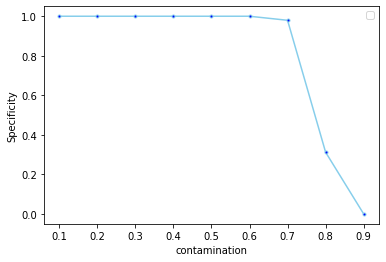

In [22]:
# Evolution de spécificité et rappel
plt.plot(CONT_contamination_IF_Shuttle, CONT_specificity_IF_Shuttle, "b-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
#plt.title("Courbe Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('contamination')
plt.ylabel('Specificity')
plt.legend(loc="best")
plt.savefig('contamination_specificity.png')
plt.show()

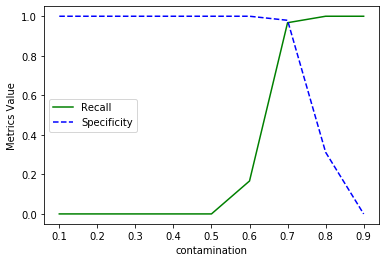

In [23]:
# Evolution de spécificité et rappel
plt.plot(CONT_contamination_IF_Shuttle, CONT_recalls_IF_Shuttle, "g-", label="Recall")
plt.plot(CONT_contamination_IF_Shuttle, CONT_specificity_IF_Shuttle, "b--", label="Specificity")
#plt.title("Courbe Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('contamination')
plt.ylabel('Metrics Value')
plt.legend(loc="best")
plt.savefig('contamination_specificity_recall_curve.png')
plt.show()

No handles with labels found to put in legend.


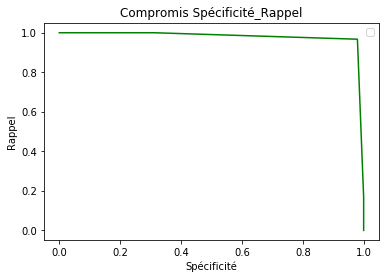

In [24]:
# Evolution de spécificité et rappel
plt.plot(CONT_specificity_IF_Shuttle, CONT_recalls_IF_Shuttle, "g-")
plt.title("Compromis Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('Spécificité')
plt.ylabel('Rappel')
plt.legend(loc="best")
    
plt.show()

### Exécution de Isolation Forest sur le jeux de données Shuttle en faisant varier la combinaison entre n_estimators et max_samples

n_estimators = 10
max_samples = 100
[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [42169  3417]]
max_samples = 2100
[[  878     0]
 [ 8275 37311]]
max_samples = 3100
[[  864    14]
 [ 3110 42476]]
max_samples = 4100
[[  867    11]
 [ 2676 42910]]
max_samples = 5100
[[  869     9]
 [ 3931 41655]]
max_samples = 6100
[[  861    17]
 [ 2686 42900]]
max_samples = 7100
[[  852    26]
 [  693 44893]]
max_samples = 8100
[[  859    19]
 [ 1408 44178]]
max_samples = 9100
[[  858    20]
 [  473 45113]]


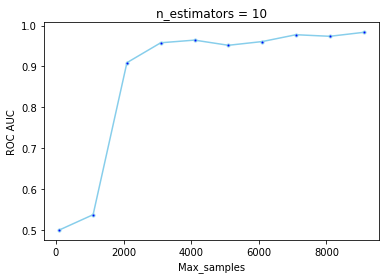

n_estimators = 20
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [32419 13167]]
max_samples = 2100
[[  877     1]
 [ 6122 39464]]
max_samples = 3100
[[  878     0]
 [ 7792 37794]]
max_samples = 4100
[[  871     7]
 [ 1809 43777]]
max_samples = 5100
[[  869     9]
 [ 1609 43977]]
max_samples = 6100
[[  857    21]
 [  621 44965]]
max_samples = 7100
[[  863    15]
 [  570 45016]]
max_samples = 8100
[[  855    23]
 [  322 45264]]
max_samples = 9100
[[  855    23]
 [  358 45228]]


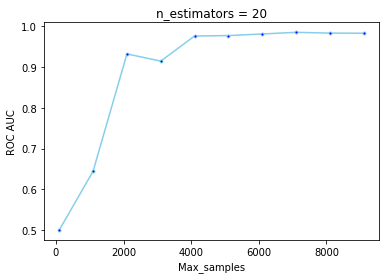

n_estimators = 30
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [31150 14436]]
max_samples = 2100
[[  875     3]
 [ 8651 36935]]
max_samples = 3100
[[  877     1]
 [ 7425 38161]]
max_samples = 4100
[[  874     4]
 [ 2958 42628]]
max_samples = 5100
[[  863    15]
 [ 1220 44366]]
max_samples = 6100
[[  859    19]
 [  811 44775]]
max_samples = 7100
[[  860    18]
 [  508 45078]]
max_samples = 8100
[[  858    20]
 [  433 45153]]
max_samples = 9100
[[  862    16]
 [  455 45131]]


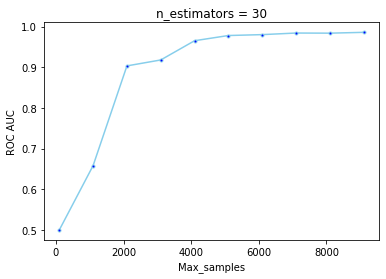

n_estimators = 40
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [27563 18023]]
max_samples = 2100
[[  878     0]
 [ 7282 38304]]
max_samples = 3100
[[  878     0]
 [ 5648 39938]]
max_samples = 4100
[[  873     5]
 [ 2293 43293]]
max_samples = 5100
[[  865    13]
 [ 1821 43765]]
max_samples = 6100
[[  870     8]
 [  924 44662]]
max_samples = 7100
[[  862    16]
 [  442 45144]]
max_samples = 8100
[[  859    19]
 [  514 45072]]
max_samples = 9100
[[  860    18]
 [  459 45127]]


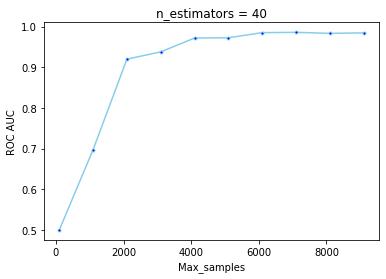

n_estimators = 50
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [36128  9458]]
max_samples = 2100
[[  878     0]
 [11144 34442]]
max_samples = 3100
[[  876     2]
 [ 3080 42506]]
max_samples = 4100
[[  872     6]
 [ 3233 42353]]
max_samples = 5100
[[  866    12]
 [ 1130 44456]]
max_samples = 6100
[[  868    10]
 [ 1433 44153]]
max_samples = 7100
[[  857    21]
 [  791 44795]]
max_samples = 8100
[[  859    19]
 [  563 45023]]
max_samples = 9100
[[  791    87]
 [  324 45262]]


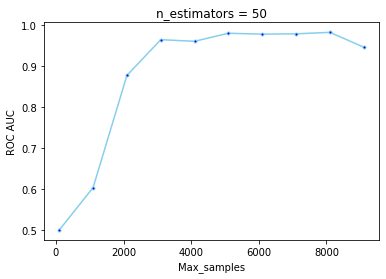

n_estimators = 60
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [28555 17031]]
max_samples = 2100
[[  878     0]
 [10306 35280]]
max_samples = 3100
[[  877     1]
 [ 4309 41277]]
max_samples = 4100
[[  873     5]
 [ 2068 43518]]
max_samples = 5100
[[  873     5]
 [ 1678 43908]]
max_samples = 6100
[[  862    16]
 [  824 44762]]
max_samples = 7100
[[  862    16]
 [  666 44920]]
max_samples = 8100
[[  855    23]
 [  408 45178]]
max_samples = 9100
[[  852    26]
 [  235 45351]]


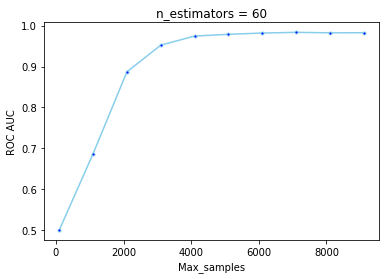

n_estimators = 70
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [35157 10429]]
max_samples = 2100
[[  878     0]
 [ 9479 36107]]
max_samples = 3100
[[  875     3]
 [ 6078 39508]]
max_samples = 4100
[[  874     4]
 [ 2305 43281]]
max_samples = 5100
[[  869     9]
 [ 1864 43722]]
max_samples = 6100
[[  864    14]
 [  915 44671]]
max_samples = 7100
[[  861    17]
 [  503 45083]]
max_samples = 8100
[[  859    19]
 [  414 45172]]
max_samples = 9100
[[  861    17]
 [  395 45191]]


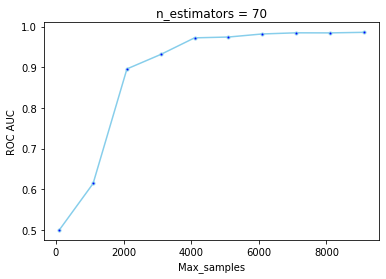

n_estimators = 80
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [36419  9167]]
max_samples = 2100
[[  878     0]
 [ 9861 35725]]
max_samples = 3100
[[  877     1]
 [ 5058 40528]]
max_samples = 4100
[[  870     8]
 [ 2566 43020]]
max_samples = 5100
[[  873     5]
 [ 1205 44381]]
max_samples = 6100
[[  866    12]
 [ 1115 44471]]
max_samples = 7100
[[  863    15]
 [  989 44597]]
max_samples = 8100
[[  853    25]
 [  349 45237]]
max_samples = 9100
[[  840    38]
 [  245 45341]]


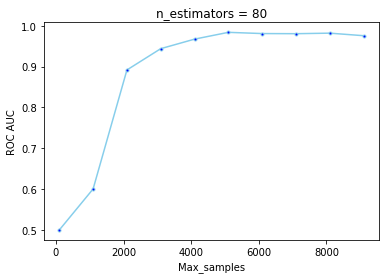

n_estimators = 90
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [34630 10956]]
max_samples = 2100
[[  878     0]
 [10049 35537]]
max_samples = 3100
[[  876     2]
 [ 4782 40804]]
max_samples = 4100
[[  872     6]
 [ 2423 43163]]
max_samples = 5100
[[  873     5]
 [ 1221 44365]]
max_samples = 6100
[[  864    14]
 [  861 44725]]
max_samples = 7100
[[  861    17]
 [  617 44969]]
max_samples = 8100
[[  859    19]
 [  411 45175]]
max_samples = 9100
[[  854    24]
 [  307 45279]]


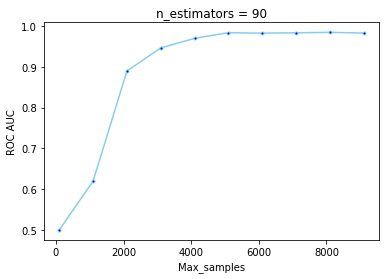

n_estimators = 100
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [34161 11425]]
max_samples = 2100
[[  878     0]
 [11814 33772]]
max_samples = 3100
[[  876     2]
 [ 5471 40115]]
max_samples = 4100
[[  874     4]
 [ 1795 43791]]
max_samples = 5100
[[  866    12]
 [ 1365 44221]]
max_samples = 6100
[[  866    12]
 [ 1215 44371]]
max_samples = 7100
[[  861    17]
 [  682 44904]]
max_samples = 8100
[[  854    24]
 [  294 45292]]
max_samples = 9100
[[  860    18]
 [  353 45233]]


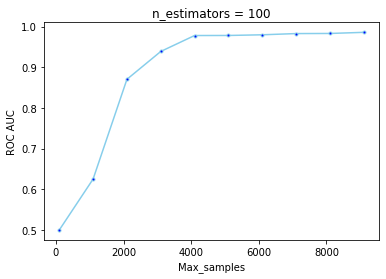

n_estimators = 110
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [30136 15450]]
max_samples = 2100
[[  878     0]
 [ 8818 36768]]
max_samples = 3100
[[  876     2]
 [ 4422 41164]]
max_samples = 4100
[[  872     6]
 [ 2988 42598]]
max_samples = 5100
[[  870     8]
 [ 1157 44429]]
max_samples = 6100
[[  867    11]
 [  880 44706]]
max_samples = 7100
[[  861    17]
 [  656 44930]]
max_samples = 8100
[[  860    18]
 [  430 45156]]
max_samples = 9100
[[  858    20]
 [  347 45239]]


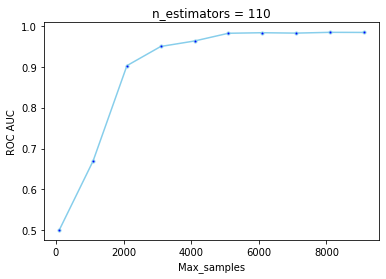

n_estimators = 120
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [26593 18993]]
max_samples = 2100
[[  878     0]
 [10335 35251]]
max_samples = 3100
[[  878     0]
 [ 5857 39729]]
max_samples = 4100
[[  871     7]
 [ 2042 43544]]
max_samples = 5100
[[  868    10]
 [ 1022 44564]]
max_samples = 6100
[[  863    15]
 [  646 44940]]
max_samples = 7100
[[  859    19]
 [  689 44897]]
max_samples = 8100
[[  860    18]
 [  520 45066]]
max_samples = 9100
[[  860    18]
 [  369 45217]]


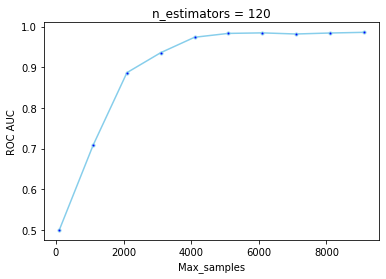

n_estimators = 130
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [31241 14345]]
max_samples = 2100
[[  878     0]
 [ 9772 35814]]
max_samples = 3100
[[  878     0]
 [ 4104 41482]]
max_samples = 4100
[[  869     9]
 [ 2619 42967]]
max_samples = 5100
[[  867    11]
 [ 1358 44228]]
max_samples = 6100
[[  867    11]
 [  764 44822]]
max_samples = 7100
[[  864    14]
 [  727 44859]]
max_samples = 8100
[[  858    20]
 [  454 45132]]
max_samples = 9100
[[  860    18]
 [  296 45290]]


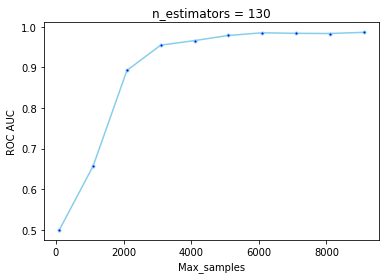

n_estimators = 140
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [34979 10607]]
max_samples = 2100
[[  878     0]
 [ 9654 35932]]
max_samples = 3100
[[  876     2]
 [ 5263 40323]]
max_samples = 4100
[[  872     6]
 [ 2293 43293]]
max_samples = 5100
[[  870     8]
 [ 1386 44200]]
max_samples = 6100
[[  861    17]
 [ 1097 44489]]
max_samples = 7100
[[  861    17]
 [  600 44986]]
max_samples = 8100
[[  855    23]
 [  481 45105]]
max_samples = 9100
[[  853    25]
 [  307 45279]]


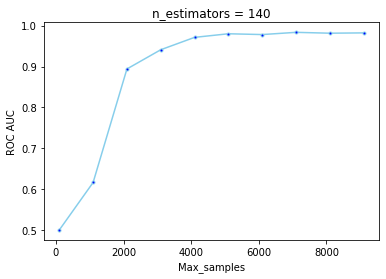

n_estimators = 150
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [31606 13980]]
max_samples = 2100
[[  878     0]
 [ 7619 37967]]
max_samples = 3100
[[  878     0]
 [ 5402 40184]]
max_samples = 4100
[[  874     4]
 [ 2028 43558]]
max_samples = 5100
[[  873     5]
 [ 1385 44201]]
max_samples = 6100
[[  862    16]
 [  912 44674]]
max_samples = 7100
[[  861    17]
 [  704 44882]]
max_samples = 8100
[[  860    18]
 [  458 45128]]
max_samples = 9100
[[  856    22]
 [  291 45295]]


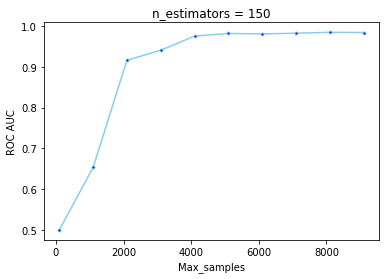

n_estimators = 160
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [35839  9747]]
max_samples = 2100
[[  878     0]
 [ 8223 37363]]
max_samples = 3100
[[  875     3]
 [ 5309 40277]]
max_samples = 4100
[[  873     5]
 [ 2146 43440]]
max_samples = 5100
[[  871     7]
 [ 1246 44340]]
max_samples = 6100
[[  867    11]
 [  857 44729]]
max_samples = 7100
[[  859    19]
 [  608 44978]]
max_samples = 8100
[[  860    18]
 [  407 45179]]
max_samples = 9100
[[  859    19]
 [  325 45261]]


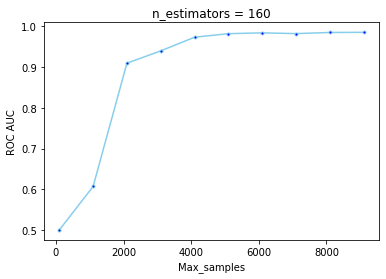

n_estimators = 170
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [32898 12688]]
max_samples = 2100
[[  878     0]
 [10168 35418]]
max_samples = 3100
[[  877     1]
 [ 5599 39987]]
max_samples = 4100
[[  872     6]
 [ 2108 43478]]
max_samples = 5100
[[  866    12]
 [ 1366 44220]]
max_samples = 6100
[[  863    15]
 [  924 44662]]
max_samples = 7100
[[  861    17]
 [  741 44845]]
max_samples = 8100
[[  859    19]
 [  499 45087]]
max_samples = 9100
[[  861    17]
 [  394 45192]]


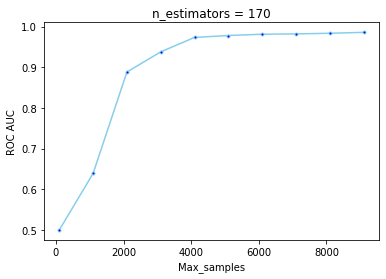

n_estimators = 180
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [31926 13660]]
max_samples = 2100
[[  878     0]
 [ 9651 35935]]
max_samples = 3100
[[  874     4]
 [ 5313 40273]]
max_samples = 4100
[[  872     6]
 [ 1881 43705]]
max_samples = 5100
[[  869     9]
 [ 1208 44378]]
max_samples = 6100
[[  863    15]
 [  857 44729]]
max_samples = 7100
[[  861    17]
 [  797 44789]]
max_samples = 8100
[[  857    21]
 [  412 45174]]
max_samples = 9100
[[  857    21]
 [  320 45266]]


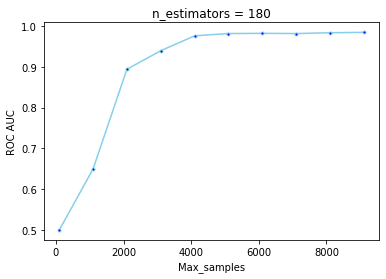

n_estimators = 190
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [35374 10212]]
max_samples = 2100
[[  878     0]
 [10054 35532]]
max_samples = 3100
[[  875     3]
 [ 4624 40962]]
max_samples = 4100
[[  874     4]
 [ 2362 43224]]
max_samples = 5100
[[  865    13]
 [ 1522 44064]]
max_samples = 6100
[[  870     8]
 [  909 44677]]
max_samples = 7100
[[  859    19]
 [  577 45009]]
max_samples = 8100
[[  856    22]
 [  456 45130]]
max_samples = 9100
[[  857    21]
 [  298 45288]]


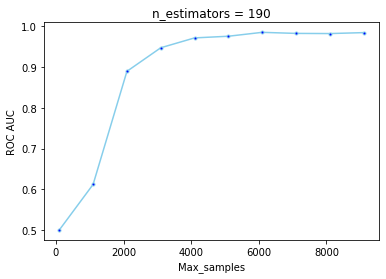

n_estimators = 200
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [34757 10829]]
max_samples = 2100
[[  878     0]
 [10613 34973]]
max_samples = 3100
[[  875     3]
 [ 5223 40363]]
max_samples = 4100
[[  872     6]
 [ 2133 43453]]
max_samples = 5100
[[  869     9]
 [ 1428 44158]]
max_samples = 6100
[[  867    11]
 [  829 44757]]
max_samples = 7100
[[  861    17]
 [  640 44946]]
max_samples = 8100
[[  858    20]
 [  456 45130]]
max_samples = 9100
[[  858    20]
 [  352 45234]]


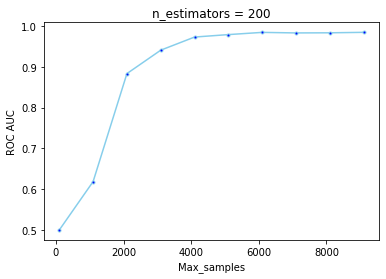

n_estimators = 210
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [35987  9599]]
max_samples = 2100
[[  878     0]
 [10606 34980]]
max_samples = 3100
[[  876     2]
 [ 5775 39811]]
max_samples = 4100
[[  872     6]
 [ 2507 43079]]
max_samples = 5100
[[  869     9]
 [ 1459 44127]]
max_samples = 6100
[[  863    15]
 [  966 44620]]
max_samples = 7100
[[  861    17]
 [  690 44896]]
max_samples = 8100
[[  860    18]
 [  376 45210]]
max_samples = 9100
[[  855    23]
 [  394 45192]]


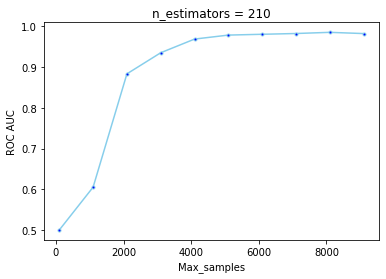

n_estimators = 220
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [32627 12959]]
max_samples = 2100
[[  878     0]
 [ 9856 35730]]
max_samples = 3100
[[  875     3]
 [ 5004 40582]]
max_samples = 4100
[[  873     5]
 [ 1956 43630]]
max_samples = 5100
[[  866    12]
 [ 1285 44301]]
max_samples = 6100
[[  862    16]
 [  910 44676]]
max_samples = 7100
[[  861    17]
 [  632 44954]]
max_samples = 8100
[[  860    18]
 [  419 45167]]
max_samples = 9100
[[  854    24]
 [  336 45250]]


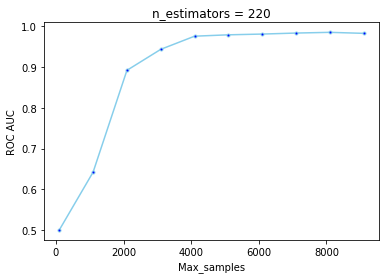

n_estimators = 230
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [33608 11978]]
max_samples = 2100
[[  878     0]
 [10734 34852]]
max_samples = 3100
[[  878     0]
 [ 4885 40701]]
max_samples = 4100
[[  873     5]
 [ 2594 42992]]
max_samples = 5100
[[  869     9]
 [ 1180 44406]]
max_samples = 6100
[[  861    17]
 [  779 44807]]
max_samples = 7100
[[  861    17]
 [  518 45068]]
max_samples = 8100
[[  856    22]
 [  439 45147]]
max_samples = 9100
[[  860    18]
 [  344 45242]]


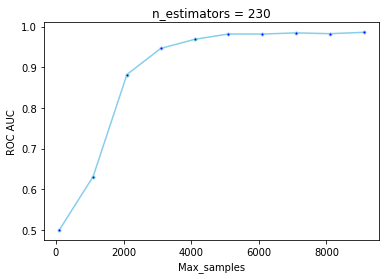

n_estimators = 240
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [31408 14178]]
max_samples = 2100
[[  878     0]
 [ 8772 36814]]
max_samples = 3100
[[  877     1]
 [ 4531 41055]]
max_samples = 4100
[[  873     5]
 [ 2445 43141]]
max_samples = 5100
[[  870     8]
 [ 1364 44222]]
max_samples = 6100
[[  864    14]
 [  877 44709]]
max_samples = 7100
[[  861    17]
 [  674 44912]]
max_samples = 8100
[[  858    20]
 [  394 45192]]
max_samples = 9100
[[  859    19]
 [  328 45258]]


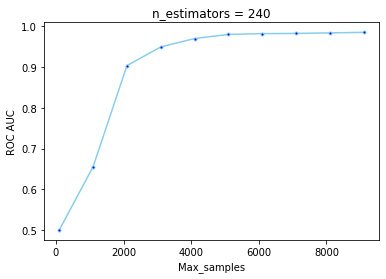

n_estimators = 250
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [34909 10677]]
max_samples = 2100
[[  878     0]
 [ 9082 36504]]
max_samples = 3100
[[  875     3]
 [ 4740 40846]]
max_samples = 4100
[[  873     5]
 [ 2190 43396]]
max_samples = 5100
[[  870     8]
 [ 1299 44287]]
max_samples = 6100
[[  864    14]
 [ 1012 44574]]
max_samples = 7100
[[  861    17]
 [  684 44902]]
max_samples = 8100
[[  860    18]
 [  518 45068]]
max_samples = 9100
[[  860    18]
 [  377 45209]]


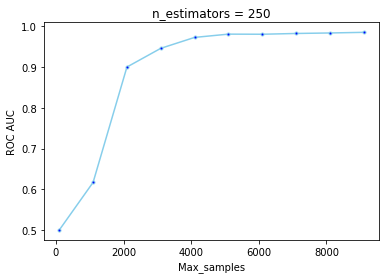

n_estimators = 260
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [32993 12593]]
max_samples = 2100
[[  878     0]
 [10059 35527]]
max_samples = 3100
[[  878     0]
 [ 4480 41106]]
max_samples = 4100
[[  873     5]
 [ 2369 43217]]
max_samples = 5100
[[  871     7]
 [ 1404 44182]]
max_samples = 6100
[[  864    14]
 [  838 44748]]
max_samples = 7100
[[  860    18]
 [  643 44943]]
max_samples = 8100
[[  861    17]
 [  564 45022]]
max_samples = 9100
[[  854    24]
 [  344 45242]]


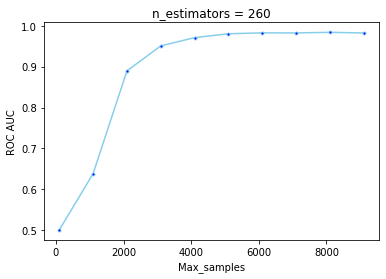

n_estimators = 270
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [37366  8220]]
max_samples = 2100
[[  878     0]
 [ 9603 35983]]
max_samples = 3100
[[  875     3]
 [ 4430 41156]]
max_samples = 4100
[[  874     4]
 [ 1780 43806]]
max_samples = 5100
[[  871     7]
 [ 1344 44242]]
max_samples = 6100
[[  863    15]
 [  846 44740]]
max_samples = 7100
[[  860    18]
 [  658 44928]]
max_samples = 8100
[[  857    21]
 [  468 45118]]
max_samples = 9100
[[  860    18]
 [  379 45207]]


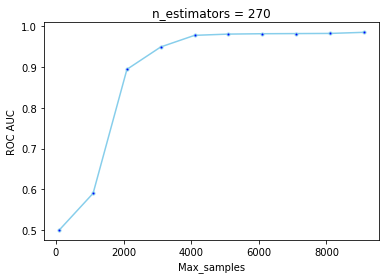

n_estimators = 280
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [35483 10103]]
max_samples = 2100
[[  878     0]
 [ 9645 35941]]
max_samples = 3100
[[  878     0]
 [ 5055 40531]]
max_samples = 4100
[[  873     5]
 [ 1945 43641]]
max_samples = 5100
[[  869     9]
 [ 1526 44060]]
max_samples = 6100
[[  861    17]
 [  840 44746]]
max_samples = 7100
[[  862    16]
 [  712 44874]]
max_samples = 8100
[[  859    19]
 [  391 45195]]
max_samples = 9100
[[  858    20]
 [  335 45251]]


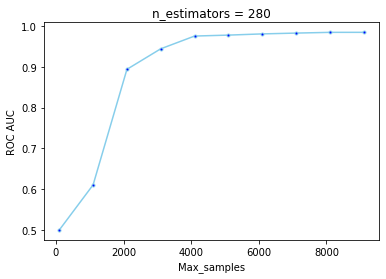

n_estimators = 290
max_samples = 100


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  878     0]
 [45586     0]]
max_samples = 1100
[[  878     0]
 [34359 11227]]
max_samples = 2100
[[  878     0]
 [ 9135 36451]]
max_samples = 3100
[[  875     3]
 [ 4747 40839]]
max_samples = 4100
[[  873     5]
 [ 2187 43399]]
max_samples = 5100
[[  872     6]
 [ 1250 44336]]
max_samples = 6100
[[  863    15]
 [ 1004 44582]]
max_samples = 7100
[[  860    18]
 [  598 44988]]
max_samples = 8100
[[  855    23]
 [  443 45143]]
max_samples = 9100
[[  855    23]
 [  338 45248]]


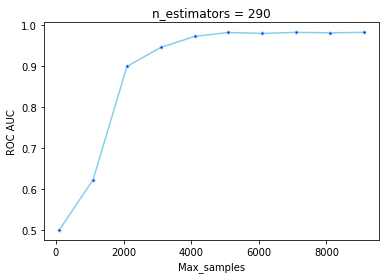

In [26]:
GENE_executions_time_IF_Shuttle = []
GENE_roc_auc_IF_Shuttle = []
GENE_roc_auc_IF_Shuttle_par_nestimators = []
GENE_precisions_IF_Shuttle = []
GENE_recalls_IF_Shuttle = []
GENE_f1_scores_IF_Shuttle = []
GENE_tn_IF_Shuttle = []
GENE_fp_IF_Shuttle = []
GENE_fn_IF_Shuttle = []
GENE_tp_IF_Shuttle = []
GENE_specificity_IF_Shuttle = []
GENE_contamination_IF_Shuttle = []
GENE_n_estimators_IF_Shuttle = []
GENE_max_samples_IF_Shuttle = []

contamination = 'auto'

for j in range(10, 300, 10):
    print("n_estimators = "+str(j))
    n_estimators = j
    GENE_roc_auc_IF_Shuttle_par_nestimators = []
    for k in range(100, 10100, 1000):
        print("max_samples = "+str(k))
        max_samples = k
        GENE_n_estimators_IF_Shuttle.append(j)
        GENE_max_samples_IF_Shuttle.append(k)
        #for f in np.arange(0., 0.5, 0.01):
        #    print("contamination = "+str(f))
        #    contamination = f
        #    GENE_contamination_IF_Shuttle.append(f)
        start_IF_Shuttle = time()

        # Instanciation, fit and predict on Shuttle
        GENE_func_IF_Shuttle = IsolationForest.IsolationForest(sample_size = max_samples, n_trees=n_estimators)
        GENE_func_IF_Shuttle.fit(X_Shuttle)
        GENE_y_pred_IF_Shuttle = GENE_func_IF_Shuttle.predict(X_Shuttle, threshold=threshold)

        # Calcul du temps d'exécution
        GENE_exec_time_IF_Shuttle = time() - start_IF_Shuttle
        GENE_executions_time_IF_Shuttle.append(GENE_exec_time_IF_Shuttle)

        # Precision
        GENE_precisions_IF_Shuttle.append(precision_score(y_transform_Shuttle, GENE_y_pred_IF_Shuttle))

        # Recall
        GENE_recalls_IF_Shuttle.append(recall_score(y_transform_Shuttle, GENE_y_pred_IF_Shuttle))

        # f1_score
        GENE_f1_scores_IF_Shuttle.append(f1_score(y_transform_Shuttle, GENE_y_pred_IF_Shuttle))

        # Specificity
        GENE_specificity_IF_Shuttle.append(specificity_score(y_transform_Shuttle, GENE_y_pred_IF_Shuttle))

        # Matrice de confusion
        print(confusion_matrix(y_transform_Shuttle, GENE_y_pred_IF_Shuttle))
        ttn, tfp, tfn, ttp = confusion_matrix(y_transform_Shuttle, GENE_y_pred_IF_Shuttle).ravel()
        tn = ttp
        fp = tfn
        fn = tfp
        tp = ttn
        GENE_tn_IF_Shuttle.append(tn)
        GENE_fp_IF_Shuttle.append(fp)
        GENE_fn_IF_Shuttle.append(fn)
        GENE_tp_IF_Shuttle.append(tp)

        # Calcul de l'aire sous la courbe ROC
        #GENE_y_DF_IF_Shuttle = GENE_func_IF_Shuttle.decision_function(X_Shuttle)
        GENE_auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, GENE_y_pred_IF_Shuttle)
        GENE_roc_auc_IF_Shuttle_par_nestimators.append(GENE_auc_IF_Shuttle)
        
    GENE_roc_auc_IF_Shuttle.append(GENE_roc_auc_IF_Shuttle_par_nestimators)
        
    plt.plot(range(100, 10100, 1000),GENE_roc_auc_IF_Shuttle_par_nestimators,  "b-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
    plt.title("n_estimators = "+str(j))
    #plt.axis([0, 1, 0, 1])
    plt.xlabel('Max_samples')
    plt.ylabel('ROC AUC')
    plt.show()

In [27]:
GENE_index = GENE_roc_auc_IF_Shuttle.index(max(GENE_roc_auc_IF_Shuttle))
print("La meilleure est "+str(max(GENE_roc_auc_IF_Shuttle))+" pour un temps d'exécution de "+str(GENE_executions_time_IF_Shuttle[GENE_index])+"s obtenue avec une contamination de "+str('auto')+" avec un max_samples de "+str(GENE_max_samples_IF_Shuttle[GENE_index])+" et avec un n_estimators de "+str(GENE_n_estimators_IF_Shuttle[GENE_index])+" donnant un rappel de "+str(GENE_recalls_IF_Shuttle[GENE_index])+" et une spécificité de "+str(GENE_specificity_IF_Shuttle[GENE_index]))


La meilleure est [0.5, 0.7083205370069758, 0.8866428289387093, 0.9357587855920677, 0.973616440207085, 0.983095657290778, 0.9843723500611175, 0.981622809704494, 0.9840459250617146, 0.9857021353017006] pour un temps d'exécution de 20.781069040298462s obtenue avec une contamination de auto avec un max_samples de 1100 et avec un n_estimators de 20 donnant un rappel de 0.2888386785416575 et une spécificité de 1.0


ValueError: 'c' argument has 29 elements, which is not acceptable for use with 'x' with size 290, 'y' with size 290.

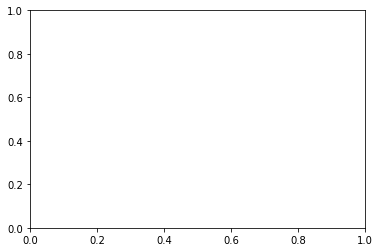

In [28]:
plt.scatter(GENE_max_samples_IF_Shuttle,GENE_n_estimators_IF_Shuttle, c=GENE_roc_auc_IF_Shuttle, cmap=cm.hsv)
plt.title("Compromis Spécificité_Rappel")
#plt.axis([0, 1, 0, 1])
plt.xlabel('Max_samples')
plt.ylabel('n_estimators')
cbar= plt.colorbar()
plt.show()

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(GENE_max_samples_IF_Shuttle, GENE_n_estimators_IF_Shuttle, GENE_roc_auc_IF_Shuttle, c=GENE_roc_auc_IF_Shuttle, cmap='Greens')


In [ ]:
X, Y, Z = np.meshgrid(GENE_max_samples_IF_Shuttle, GENE_n_estimators_IF_Shuttle, GENE_roc_auc_IF_Shuttle)
print(GENE_roc_auc_IF_Shuttle)
ax.contour3D(X,Y,Z, 50, cmap='binary')

### Interprétation du résultat de IsolationForest sur Shuttle

###### Faisant varier n_estimators

###### Faisant varier max_samples

###### Faisant varier contamination

###### Meilleure combinaison entre n_estimators et max_samples

###### Meilleure combinaison entre n_estimators et contamination

###### Meilleure combinaison entre max_samples et contamination

###### Meilleure combinaison entre max_samples, n_estimators et contamination

In [ ]:
GENE_roc_auc_IF_Shuttle = []
GENE_n_estimators_IF_Shuttle = []
GENE_max_samples_IF_Shuttle = []

min_roc_auc = 0.9734066937187585

for j in range(100, 10100, 200):
    print("max_samples = "+str(j))
    max_samples = j
    k = 10
    while k <= 300:
        print("n_estimators = "+str(k))
        n_estimators = k

        # Instanciation, fit and predict on Shuttle
        GENE_func_IF_Shuttle = IsolationForest.IsolationForest(sample_size = max_samples, n_trees=n_estimators)
        GENE_func_IF_Shuttle.fit(X_Shuttle)
        GENE_y_pred_IF_Shuttle = GENE_func_IF_Shuttle.predict(X_Shuttle, threshold=threshold)

        # Calcul de l'aire sous la courbe ROC
        #y_DF_IF_Shuttle = GENE_func_IF_Shuttle.decision_function(X_Shuttle)

        auc_IF_Shuttle = roc_auc_score(y_transform_Shuttle, GENE_y_pred_IF_Shuttle)
        if auc_IF_Shuttle < min_roc_auc:
            k = k + 10
        else:
            print("auc_IF_Shuttle = "+str(auc_IF_Shuttle))
            GENE_roc_auc_IF_Shuttle.append(auc_IF_Shuttle)
            GENE_n_estimators_IF_Shuttle.append(k)
            GENE_max_samples_IF_Shuttle.append(j)
            k = 310
        
plt.plot(GENE_max_samples_IF_Shuttle,GENE_n_estimators_IF_Shuttle,  "b-", marker='.', markerfacecolor='blue', markersize=6, color='skyblue')
plt.title("ROC AUC Min = "+str(min_roc_auc))
#plt.axis([0, 1, 0, 1])
plt.xlabel('Max_samples')
plt.ylabel('n_estimators')
plt.show()